### Linear Regression Model

In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [3]:
# Fill missing values for numerical + categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna('Unknown'))

# Remove duplicates
df = df.drop_duplicates()

# Handle 'genres' column (multi-label encoding)
df['genres'] = df['genres'].fillna('Unknown')
df['genres'] = df['genres'].apply(lambda x: x.split(', '))
unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

# Retain 'genres' column for now as per the requirement
# Columns to encode
encode_cols = ['original_language', 'type', 'status', 'created_by', 'networks', 'origin_country', 'production_companies']

# One-hot encoding for 'original_language' (top 10 values + 'OTHER')
top_10_original_language = df['original_language'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_original_language:
    df[f'original-language_{i}'] = np.where(df['original_language'] == i, 1, 0)
df['original-language_OTHER'] = (~df['original_language'].isin(top_10_original_language)).astype(int)
df.drop(columns=['original_language'], inplace=True)
encode_cols.remove('original_language')

# One-hot encoding for 'created_by' (top 10 values + 'OTHER')
filtered_df = df[df['created_by'] != 'Unknown']
top_10_created_by = filtered_df['created_by'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_created_by:
    df[f'created-by_{i}'] = np.where(df['created_by'] == i, 1, 0)
df['created-by_OTHER'] = (~df['created_by'].isin(top_10_created_by)).astype(int)
df.drop(columns=['created_by'], inplace=True)
encode_cols.remove('created_by')

# One-hot encoding for 'networks' (top 10 values + 'OTHER')
filtered_df = df[df['networks'] != 'Unknown']
top_10_networks = filtered_df['networks'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_networks:
    df[f'networks_{i}'] = np.where(df['networks'] == i, 1, 0)
df['networks_OTHER'] = (~df['networks'].isin(top_10_networks)).astype(int)
df.drop(columns=['networks'], inplace=True)
encode_cols.remove('networks')

# One-hot encoding for 'origin_country' (top 10 values + 'OTHER')
df['origin_country'] = df['origin_country'].fillna('Unknown')
filtered_df = df[df['origin_country'] != 'Unknown']
top_10_origin_country = filtered_df['origin_country'].value_counts(ascending=False).head(10).index.tolist()
one_hot_encoded = pd.get_dummies(df['origin_country'], prefix='origin-country')
one_hot_encoded = one_hot_encoded[[f'origin-country_{i}' for i in top_10_origin_country if f'origin-country_{i}' in one_hot_encoded]]
one_hot_encoded['origin-country_OTHER'] = (~df['origin_country'].isin(top_10_origin_country)).astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['origin_country'], inplace=True)
encode_cols.remove('origin_country')

# One-hot encoding for 'production_companies' (top 10 values + 'OTHER')
df['production_companies'] = df['production_companies'].fillna('Unknown')
filtered_df = df[df['production_companies'] != 'Unknown']
top_10_production_companies = filtered_df['production_companies'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_production_companies:
    df[f'production-companies_{i}'] = np.where(df['production_companies'] == i, 1, 0)
df['production-companies_OTHER'] = (~df['production_companies'].isin(top_10_production_companies)).astype(int)
df.drop(columns=['production_companies'], inplace=True)
encode_cols.remove('production_companies')

# One-hot encoding for remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname)
    df = pd.concat([df, df_encoded], axis=1)

# Removing remaining original columns from df
df.drop(columns=encode_cols, axis=1, inplace=True)

# Save the final DataFrame
df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

# Print final DataFrame columns to verify
print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=120)


In [4]:
# Iterate through the columns and print each
for col in df.columns:
    print(col)

id
name
number_of_seasons
number_of_episodes
vote_count
vote_average
overview
adult
backdrop_path
first_air_date
last_air_date
homepage
in_production
original_name
popularity
poster_path
tagline
genres
languages
spoken_languages
production_countries
episode_run_time
cleaned_overview
has_family
has_life
has_love
has_young
has_school
has_man
has_girl
has_father
Action & Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
History
Kids
Music
Musical
Mystery
News
Reality
Romance
Sci-Fi & Fantasy
Soap
Talk
Unknown
War & Politics
Western
original-language_en
original-language_zh
original-language_ja
original-language_ko
original-language_de
original-language_fr
original-language_es
original-language_pt
original-language_ru
original-language_nl
original-language_OTHER
created-by_Shotaro Ishinomori
created-by_John de Mol
created-by_Adrián Suar
created-by_Simon Fuller
created-by_Ekta Kapoor
created-by_Na Young-seok
created-by_Yang Li-Hua
created-by_Joseph Barbera, William Hanna
created-by_

In [5]:
# convert the boolean values to integers (True -> 1, False -> 0)
df['adult'] = df['adult'].astype(int)

In [6]:
# Replace "Unknown" and other invalid date strings with NaT (Not a Time)
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format='%Y-%m-%d', errors='coerce')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format='%Y-%m-%d', errors='coerce')

# Check the data types to confirm conversion
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to determine the season based on the month
def get_season(date):
    if pd.isna(date):  # Handle NaT values
        return 'UNKNOWN'
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'

# Creating a column with the seasons for `first_air_date`
df['first_air_date_season'] = df['first_air_date'].apply(get_season)

# Creating boolean columns for each season
df['first_air_date_winter'] = (df['first_air_date_season'] == 'WINTER').astype(int)
df['first_air_date_spring'] = (df['first_air_date_season'] == 'SPRING').astype(int)
df['first_air_date_summer'] = (df['first_air_date_season'] == 'SUMMER').astype(int)
df['first_air_date_fall'] = (df['first_air_date_season'] == 'FALL').astype(int)

# Repeating the same process for `last_air_date`
df['last_air_date_season'] = df['last_air_date'].apply(get_season)

df['last_air_date_winter'] = (df['last_air_date_season'] == 'WINTER').astype(int)
df['last_air_date_spring'] = (df['last_air_date_season'] == 'SPRING').astype(int)
df['last_air_date_summer'] = (df['last_air_date_season'] == 'SUMMER').astype(int)
df['last_air_date_fall'] = (df['last_air_date_season'] == 'FALL').astype(int)

# Confirm the columns
print(df[['first_air_date_season', 'last_air_date_season']].head())


datetime64[ns]
datetime64[ns]
  first_air_date_season last_air_date_season
0                SPRING               SPRING
1                SPRING               WINTER
2                SUMMER               SUMMER
3                  FALL                 FALL
4                WINTER                 FALL


In [7]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

      id              name  number_of_seasons  number_of_episodes  vote_count  \
0   1399   Game of Thrones                  8                  73       21857   
1  71446       Money Heist                  3                  41       17836   
2  66732   Stranger Things                  4                  34       16161   
3   1402  The Walking Dead                 11                 177       15432   
4  63174           Lucifer                  6                  93       13870   

   vote_average                                           overview  adult  \
0         8.442  Seven noble families fight for control of the ...      0   
1         8.257  To carry out the biggest heist in history, a m...      0   
2         8.624  When a young boy vanishes, a small town uncove...      0   
3         8.121  Sheriff's deputy Rick Grimes awakens from a co...      0   
4         8.486  Bored and unhappy as the Lord of Hell, Lucifer...      0   

                      backdrop_path first_air_date

In [8]:
# Iterate through the columns and print each
for col in df.columns:
    print(col)

id
name
number_of_seasons
number_of_episodes
vote_count
vote_average
overview
adult
backdrop_path
first_air_date
last_air_date
homepage
in_production
original_name
popularity
poster_path
tagline
genres
languages
spoken_languages
production_countries
episode_run_time
cleaned_overview
has_family
has_life
has_love
has_young
has_school
has_man
has_girl
has_father
Action & Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
History
Kids
Music
Musical
Mystery
News
Reality
Romance
Sci-Fi & Fantasy
Soap
Talk
Unknown
War & Politics
Western
original-language_en
original-language_zh
original-language_ja
original-language_ko
original-language_de
original-language_fr
original-language_es
original-language_pt
original-language_ru
original-language_nl
original-language_OTHER
created-by_Shotaro Ishinomori
created-by_John de Mol
created-by_Adrián Suar
created-by_Simon Fuller
created-by_Ekta Kapoor
created-by_Na Young-seok
created-by_Yang Li-Hua
created-by_Joseph Barbera, William Hanna
created-by_

In [9]:
#Winsorization
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column in-place
for col in numerical_columns:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column in-place
for col in numerical_columns_log:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))


In [10]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling in-place
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm normalized columns
print(df.head())

         id              name  number_of_seasons  number_of_episodes  \
0  0.005565   Game of Thrones               1.00            0.802198   
1  0.284401       Money Heist               0.75            0.450549   
2  0.265636   Stranger Things               1.00            0.373626   
3  0.005577  The Walking Dead               1.00            1.000000   
4  0.251473           Lucifer               1.00            1.000000   

   vote_count  vote_average  \
0         1.0      0.938000   
1         1.0      0.917444   
2         1.0      0.958222   
3         1.0      0.902333   
4         1.0      0.942889   

                                            overview  adult  \
0  Seven noble families fight for control of the ...    0.0   
1  To carry out the biggest heist in history, a m...    0.0   
2  When a young boy vanishes, a small town uncove...    0.0   
3  Sheriff's deputy Rick Grimes awakens from a co...    0.0   
4  Bored and unhappy as the Lord of Hell, Lucifer...    0.0   

 

In [14]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series',
        # Contains Word
        'has_father', 'has_girl', 'has_man', 'has_school', 'has_young', 
        'has_family', 'has_life', 'has_love'
]]
y = df['popularity_log']

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)  # Root Mean Squared Error
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)  # Root Mean Squared Error
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Training Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-squared (R2): {train_r2:.4f}")

print("\nTesting Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")


Training Set Metrics:
Mean Squared Error (MSE): 0.0338
Root Mean Squared Error (RMSE): 0.1837
Mean Absolute Error (MAE): 0.1283
R-squared (R2): 0.6103

Testing Set Metrics:
Mean Squared Error (MSE): 0.0335
Root Mean Squared Error (RMSE): 0.1830
Mean Absolute Error (MAE): 0.1276
R-squared (R2): 0.6080


In [15]:
# range of alpha values
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# grid search with ridge regression
ridge_cv = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

print(f"Best alpha: {ridge_cv.best_params_['alpha']}")

Best alpha: 10


In [19]:
ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-squared (R2): {train_r2:.4f}")

print("\nTesting Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")

Training Set Metrics:
Mean Squared Error (MSE): 0.0338
Root Mean Squared Error (RMSE): 0.1837
Mean Absolute Error (MAE): 0.1283
R-squared (R2): 0.6103

Testing Set Metrics:
Mean Squared Error (MSE): 0.0335
Root Mean Squared Error (RMSE): 0.1830
Mean Absolute Error (MAE): 0.1276
R-squared (R2): 0.6080


In [20]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso_cv = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

print(f"Best alpha: {lasso_cv.best_params_['alpha']}")

Best alpha: 0.01


In [21]:
lasso_model = Ridge(alpha=0.01)

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-squared (R2): {train_r2:.4f}")

print("\nTesting Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")

Training Set Metrics:
Mean Squared Error (MSE): 0.0338
Root Mean Squared Error (RMSE): 0.1837
Mean Absolute Error (MAE): 0.1283
R-squared (R2): 0.6103

Testing Set Metrics:
Mean Squared Error (MSE): 0.0335
Root Mean Squared Error (RMSE): 0.1830
Mean Absolute Error (MAE): 0.1276
R-squared (R2): 0.6080


Pre Word Features Metrics:
* Training Set Metrics:
	* Mean Squared Error (MSE): 0.0338
	* Root Mean Squared Error (RMSE): 0.1838
	* Mean Absolute Error (MAE): 0.1283
	* R-squared (R2): 0.6101

* Testing Set Metrics:
	* Mean Squared Error (MSE): 0.0335
	* Root Mean Squared Error (RMSE): 0.1830
	* Mean Absolute Error (MAE): 0.1276
	* R-squared (R2): 0.6077

Post Word Features Metrics:
* Training Set Metrics:
	* Mean Squared Error (MSE): 0.0338
	* Root Mean Squared Error (RMSE): 0.1837
	* Mean Absolute Error (MAE): 0.1283
	* R-squared (R2): 0.6103

* Testing Set Metrics:
	* Mean Squared Error (MSE): 0.0335
	* Root Mean Squared Error (RMSE): 0.1830
	* Mean Absolute Error (MAE): 0.1275
	* R-squared (R2): 0.6080

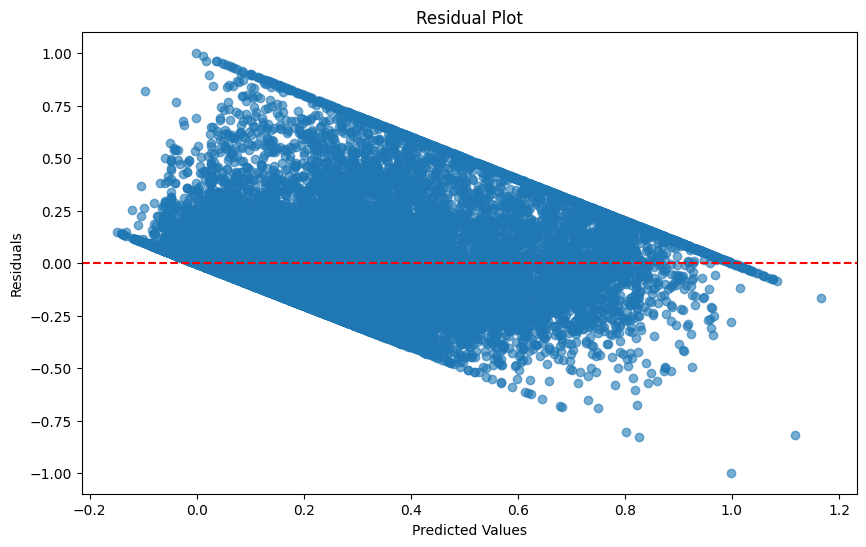

In [22]:
# https://how2matplotlib.com/how-to-create-a-residual-plot-in-python.html
residuals = y_test - y_test_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()